In [2]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import gzip
import numpy as np
import duckdb
import polars as pl
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
output_dir_enh = '/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/parquets_K562_enh'
output_dir_prom = '/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/parquets_K562_prom'

In [ ]:
os.makedirs(output_dir_enh, exist_ok=True)
os.makedirs(output_dir_prom, exist_ok=True)

In [ ]:
chunks = pd.read_csv('/work/yd90/NC_Constraint/deltaSVM_analysis/K562_Enhancer/all-CREs_for_deltaSVM.DHS_E3E_167.deltaSVM_result_for_analysis.all_chrm.txt', sep='\t',
                   chunksize=10_000, low_memory=False)
for chunk in chunks:
    table = pa.Table.from_pandas(chunk)
    pq.write_to_dataset(
        table, 
        root_path=output_dir_enh, 
        partition_cols=["chrm"],  # Partition by 'chrom' column
        compression="snappy" ,
        # existing_data_behavior="delete_matching" 
    )
        

In [ ]:
output_dir = '/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/parquets_K562_prom'
chunks = pd.read_csv('/work/yd90/NC_Constraint/deltaSVM_analysis/K562_Promoter/all-CREs_for_deltaSVM.DHS_E3_167.deltaSVM_result_for_analysis.all_chrm.txt', sep='\t',
                   chunksize=10_000, low_memory=False)
for chunk in chunks:
    table = pa.Table.from_pandas(chunk)
    pq.write_to_dataset(
        table, 
        root_path=output_dir_prom, 
        partition_cols=["chrm"],  # Partition by 'chrom' column
        compression="snappy" ,
        # existing_data_behavior="delete_matching" 
    )
        

# Map DeltaSVM to Birds and BlueSTARR 

In [ ]:
# mapped blue-birds with average input counts
blue_birds = pl.scan_csv('/hpc/group/igvf/db/blue_bird.csv.gz')

In [ ]:
# leave ref allele out of join for sanity check
delta_enh = duckdb.read_parquet(f"{output_dir_enh}/**/*.parquet", hive_partitioning=True)
delta_blue_birds_enh = duckdb.sql(
    """
    SELECT DISTINCT d.ref AS delta_ref_allele, d.delta, b.*
    FROM delta_enh d, blue_birds b
    WHERE d.chrm = b.chrom AND d.alt = b.alt_allele AND d.posg-1 = b.allele_pos
    """
).df()
delta_blue_birds_enh

In [ ]:
# leave ref allele out of join for sanity check
delta_prom = duckdb.read_parquet(f"{output_dir_prom}/**/*.parquet", hive_partitioning=True)
delta_blue_birds_prom = duckdb.sql(
    """
    SELECT DISTINCT d.ref AS delta_ref_allele, d.delta, b.*
    FROM delta_prom d, blue_birds b
    WHERE d.chrm = b.chrom AND d.alt = b.alt_allele AND d.posg-1 = b.allele_pos
    """
).df()
delta_blue_birds_prom

In [ ]:
# sanity check
delta_blue_birds_enh.loc[(delta_blue_birds_enh['ref_allele'] != delta_blue_birds_enh['blue_ref_allele']) | (delta_blue_birds_enh['blue_ref_allele'] != delta_blue_birds_enh['delta_ref_allele']), ]

In [ ]:
# sanity check
delta_blue_birds_prom.loc[(delta_blue_birds_prom['ref_allele'] != delta_blue_birds_prom['blue_ref_allele']) | (delta_blue_birds_prom['blue_ref_allele'] != delta_blue_birds_prom['delta_ref_allele']), ]

In [ ]:
delta_blue_birds_enh.to_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_enh_counts.csv.gz', compression='gzip')
delta_blue_birds_prom.to_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_prom_counts.csv.gz', compression='gzip')

In [ ]:
delta_blue_birds_enh = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_enh_counts.csv.gz', compression='gzip')
delta_blue_birds_prom = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_prom_counts.csv.gz', compression='gzip')

In [ ]:
delta_blue_birds_enh_counts = delta_blue_birds_enh
delta_blue_birds_enh_counts.loc[delta_blue_birds_enh_counts['P_reg']>=0.9, 'label'] = 1
delta_blue_birds_enh_counts.loc[delta_blue_birds_enh_counts['P_reg']<=0.3, 'label'] = 0
delta_blue_birds_enh_counts.loc[delta_blue_birds_enh_counts['theta']>1, 'class'] = 'gain'
delta_blue_birds_enh_counts.loc[delta_blue_birds_enh_counts['theta']<1, 'class'] = 'loss'
filtered_enh = delta_blue_birds_enh_counts.loc[
    ((delta_blue_birds_enh_counts['avg_input_ref'] >= 50) & (delta_blue_birds_enh_counts['label'] == 0)) |
    (delta_blue_birds_enh_counts['label'] == 1), ]

# delta_blue_birds_prom_counts = delta_blue_birds_prom
# delta_blue_birds_prom_counts.loc[delta_blue_birds_prom_counts['P_reg']>=0.9, 'label'] = 1
# delta_blue_birds_prom_counts.loc[delta_blue_birds_prom_counts['P_reg']<=0.3, 'label'] = 0
# delta_blue_birds_prom_counts.loc[delta_blue_birds_prom_counts['theta']>1, 'class'] = 'gain'
# delta_blue_birds_prom_counts.loc[delta_blue_birds_prom_counts['theta']<1, 'class'] = 'loss'
# filtered_prom = delta_blue_birds_prom_counts.loc[
#     ((delta_blue_birds_prom_counts['avg_input_ref'] >= 30) & (delta_blue_birds_prom_counts['label'] == 0)) |
#     (delta_blue_birds_prom_counts['label'] == 1), ]

In [ ]:
gain_enh = filtered_enh.loc[(filtered_enh['class'] == 'gain') & (filtered_enh['label']).notna(), ]
loss_enh = filtered_enh.loc[(filtered_enh['class'] == 'loss') & (filtered_enh['label']).notna(), ]

# gain_prom = filtered_prom.loc[(filtered_prom['class'] == 'gain') & (filtered_prom['label']).notna(), ]
# loss_prom = filtered_prom.loc[(filtered_prom['class'] == 'loss') & (filtered_prom['label']).notna(), ]


In [ ]:
gain_enh.value_counts('label')

In [ ]:
loss_enh.value_counts('label')

In [ ]:
fpr_b, tpr_b, _ = roc_curve(gain_enh['label'], gain_enh['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(gain_enh['label'], gain_enh['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer (theta > 1)")
plt.legend(loc="lower right")

plt.show()

In [ ]:
fpr_b, tpr_b, _ = roc_curve(loss_enh['label'], -loss_enh['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(loss_enh['label'], -loss_enh['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enahncer (theta < 1)")
plt.legend(loc="lower right")

plt.show()

In [ ]:
fpr_b, tpr_b, _ = roc_curve(gain_prom['label'], gain_prom['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(gain_prom['label'], gain_prom['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Promoter (theta > 1)")
plt.legend(loc="lower right")

plt.show()

In [ ]:
fpr_b, tpr_b, _ = roc_curve(loss_prom['label'], -loss_prom['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(loss_prom['label'], -loss_prom['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Promoter (theta < 1)")
plt.legend(loc="lower right")

plt.show()

check birds K562 run by A549-DMSO run

In [ ]:
delta_blue_birds_enh = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_enh_counts.csv.gz', compression='gzip')
delta_blue_birds_enh

In [ ]:
# birds pos: 1-based
delta_blue_birds_enh['Variant_ID'] = delta_blue_birds_enh['chrom']+':'+(delta_blue_birds_enh['allele_pos']+1).astype(str)+':'+delta_blue_birds_enh['ref_allele']+':'+delta_blue_birds_enh['alt_allele']
delta_blue_birds_prom['Variant_ID'] = delta_blue_birds_prom['chrom']+':'+(delta_blue_birds_prom['allele_pos']+1).astype(str)+':'+delta_blue_birds_prom['ref_allele']+':'+delta_blue_birds_prom['alt_allele']

birds_counts = pd.read_table('/work/igvf-pm/kd259/BIRD_files/BIRD_input.A549.DMSO_vs_Input.2025_01_09.txt', usecols=range(12),
                             names=['Variant_ID','Input_rep','Input1_ref','Input1_alt','Input2_ref','Input2_alt','Input3_ref','Input3_alt',
                                    'Input4_ref','Input4_alt','Input5_ref','Input5_alt'])
print(len(birds_counts.loc[birds_counts['Input_rep'] == 5, ])/len(birds_counts))
birds_counts = birds_counts.loc[birds_counts['Input_rep'] == 5, ]

birds_counts['avg_input_ref_A549'] = (birds_counts['Input1_ref']+birds_counts['Input2_ref']+birds_counts['Input3_ref']+birds_counts['Input4_ref']+birds_counts['Input5_ref'])/birds_counts['Input_rep']
# birds_counts['avg_input_alt'] = (birds_counts['Input1_alt']+birds_counts['Input2_alt']+birds_counts['Input3_alt'])/birds_counts['Input_rep']

birds_counts = birds_counts.drop(columns=['Input_rep','Input1_ref','Input1_alt','Input2_ref','Input2_alt','Input3_ref','Input3_alt',
                                    'Input4_ref','Input4_alt','Input5_ref','Input5_alt'])

delta_blue_birds_enh_counts_DMSO = pd.merge(delta_blue_birds_enh, birds_counts, how='inner', on='Variant_ID')
delta_blue_birds_prom_counts_DMSO = pd.merge(delta_blue_birds_enh, birds_counts, how='inner', on='Variant_ID')
print(len(delta_blue_birds_enh_counts_DMSO))
print(len(delta_blue_birds_prom_counts_DMSO))

In [ ]:
delta_blue_birds_enh_counts_DMSO.loc[delta_blue_birds_enh_counts_DMSO['P_reg']>=0.9, 'label'] = 1
delta_blue_birds_enh_counts_DMSO.loc[delta_blue_birds_enh_counts_DMSO['P_reg']<=0.3, 'label'] = 0
delta_blue_birds_enh_counts_DMSO.loc[delta_blue_birds_enh_counts_DMSO['theta']>1, 'class'] = 'gain'
delta_blue_birds_enh_counts_DMSO.loc[delta_blue_birds_enh_counts_DMSO['theta']<1, 'class'] = 'loss'
filtered_enh = delta_blue_birds_enh_counts_DMSO.loc[
    ((delta_blue_birds_enh_counts_DMSO['avg_input_ref'] >= 30) & (delta_blue_birds_enh_counts_DMSO['label'] == 0)) |
    (delta_blue_birds_enh_counts_DMSO['label'] == 1), ]

gain_enh = filtered_enh.loc[(filtered_enh['class'] == 'gain') & (filtered_enh['label']).notna(), ]
loss_enh = filtered_enh.loc[(filtered_enh['class'] == 'loss') & (filtered_enh['label']).notna(), ]



In [ ]:
gain_enh['label'].value_counts()

In [ ]:
loss_enh['label'].value_counts()

In [ ]:
fpr_b, tpr_b, _ = roc_curve(gain_enh['label'], gain_enh['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(gain_enh['label'], gain_enh['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM - DNA_avg_DMSO > 30")
plt.legend(loc="lower right")

plt.show()

In [ ]:
fpr_b, tpr_b, _ = roc_curve(loss_enh['label'], -loss_enh['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(loss_enh['label'], -loss_enh['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enahncer (theta < 1)")
plt.legend(loc="lower right")

plt.show()

In [ ]:
delta_blue_birds_prom_counts_DMSO

In [ ]:
delta_blue_birds_enh = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_enh_counts.csv.gz', compression='gzip')

delta_blue_birds_enh['Variant_ID'] = delta_blue_birds_enh['chrom']+':'+(delta_blue_birds_enh['allele_pos']+1).astype(str)+':'+delta_blue_birds_enh['ref_allele']+':'+delta_blue_birds_enh['alt_allele']

birds_counts = pd.read_table('/work/igvf-pm/kd259/BIRD_files/BIRD_input.A549.DMSO_vs_Input.2025_01_09.txt', usecols=range(12),
                             names=['Variant_ID','Input_rep','Input1_ref','Input1_alt','Input2_ref','Input2_alt','Input3_ref','Input3_alt','Input4_ref','Input4_alt','Input5_ref','Input5_alt'])
birds_counts = birds_counts.loc[birds_counts['Input_rep'] == 5, ]
birds_counts['avg_input_ref_A549'] = (birds_counts['Input1_ref']+birds_counts['Input2_ref']+birds_counts['Input3_ref']+birds_counts['Input4_ref']+birds_counts['Input5_ref'])/birds_counts['Input_rep']
# birds_counts['avg_input_alt'] = (birds_counts['Input1_alt']+birds_counts['Input2_alt']+birds_counts['Input3_alt'])/birds_counts['Input_rep']

# birds_counts = birds_counts.drop(columns=['Input_rep','Input1_ref','Input1_alt','Input2_ref','Input2_alt','Input3_ref','Input3_alt',
#                                     'Input4_ref','Input4_alt','Input5_ref','Input5_alt'])

delta_blue_birds_enh_counts_DMSO = pd.merge(delta_blue_birds_enh, birds_counts, how='inner', on='Variant_ID')
delta_blue_birds_enh_counts_DMSO['birds_log2_theta'] = np.log2(delta_blue_birds_enh_counts_DMSO['theta'])
delta_blue_birds_enh_counts_DMSO = delta_blue_birds_enh_counts_DMSO.drop(columns=['delta_ref_allele','chrom','ref_allele','alt_allele','blue_ref_allele','Input_rep'])
delta_blue_birds_enh_counts_DMSO

In [ ]:
delta_blue_birds_enh_counts_DMSO.loc[delta_blue_birds_enh_counts_DMSO['theta']>2,]

In [ ]:
pd.set_option('display.max_columns',None)
delta_blue_birds_enh = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_bird_delta_enh_counts.csv.gz', compression='gzip')

delta_blue_birds_enh['Variant_ID'] = delta_blue_birds_enh['chrom']+':'+(delta_blue_birds_enh['allele_pos']+1).astype(str)+':'+delta_blue_birds_enh['ref_allele']+':'+delta_blue_birds_enh['alt_allele']

birds_counts = pd.read_table('/work/igvf-pm/kd259/BIRD_files/BIRD_input.K562.2024_07_18.txt', 
                             names=['Variant_ID','Input_rep','Input1_ref','Input1_alt','Input2_ref','Input2_alt','Input3_ref','Input3_alt',
                                   'Output_rep','Output1_ref','Output1_alt','Output2_ref','Output2_alt','Output3_ref','Output3_alt'])

# birds_counts['avg_input_alt'] = (birds_counts['Input1_alt']+birds_counts['Input2_alt']+birds_counts['Input3_alt'])/birds_counts['Input_rep']
# birds_counts = birds_counts.drop(columns=['Input_rep','Input1_ref','Input1_alt','Input2_ref','Input2_alt','Input3_ref','Input3_alt',
#                                     'Input4_ref','Input4_alt','Input5_ref','Input5_alt'])

delta_blue_birds_enh_counts_DMSO = pd.merge(delta_blue_birds_enh, birds_counts, how='inner', on='Variant_ID')
delta_blue_birds_enh_counts_DMSO['birds_log2_theta'] = np.log2(delta_blue_birds_enh_counts_DMSO['theta'])
delta_blue_birds_enh_counts_DMSO = delta_blue_birds_enh_counts_DMSO.drop(columns=['delta_ref_allele','chrom','ref_allele','alt_allele','blue_ref_allele','Input_rep','Unnamed: 0'])
delta_blue_birds_enh_counts_DMSO

In [ ]:
delta_blue_birds_enh_counts_DMSO.loc[delta_blue_birds_enh_counts_DMSO['theta']>2,]

In [ ]:
delta_blue_birds_enh_counts_DMSO.loc[(delta_blue_birds_enh_counts_DMSO['theta']>0.9) & (delta_blue_birds_enh_counts_DMSO['theta']>1.1),]

# Map DeltaSVM to Kircher_2019 and BlueSTARR 

In [4]:
blue_kircher = pl.scan_csv('/hpc/group/igvf/db/blue_kircher.csv.gz')

In [6]:
# leave ref allele out of join for sanity check
delta_enh = duckdb.read_parquet(f"{output_dir_enh}/**/*.parquet", hive_partitioning=True)
delta_blue_kircher_enh = duckdb.sql(
    """
    SELECT DISTINCT d.ref AS delta_ref_allele, d.delta, b.*
    FROM delta_enh d, blue_kircher b
    WHERE d.chrm = b.chrom AND d.alt = b.alt_allele AND d.posg-1 = b.allele_pos
    """
).df()
delta_blue_kircher_enh

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,delta_ref_allele,delta,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags
0,C,-0.14,chr10,43086478,C,G,C,-0.021736,-0.21,2.957724e-02,39
1,A,1.00,chr10,43086479,A,T,A,0.021520,0.04,6.504294e-02,862
2,G,1.29,chr10,43086480,G,A,G,-0.007222,0.01,7.675571e-01,361
3,G,2.15,chr10,43086480,G,C,G,0.009869,-0.01,8.293318e-01,88
4,G,0.45,chr10,43086480,G,T,G,-0.024190,-0.00,9.042489e-01,297
...,...,...,...,...,...,...,...,...,...,...,...
5709,T,-1.82,chr7,156791426,T,C,T,0.037556,0.04,2.304270e-03,3861
5710,A,-0.22,chr7,156791466,A,G,A,-0.014174,-0.07,1.393598e-09,6413
5711,T,0.75,chr7,156791497,T,C,T,-0.001982,0.03,2.095803e-02,6183
5712,A,-0.14,chr7,156791515,A,C,A,-0.002887,-0.04,1.200148e-01,1194


In [7]:
# sanity check
delta_blue_kircher_enh.loc[(delta_blue_kircher_enh['ref_allele'] != delta_blue_kircher_enh['blue_ref_allele']) | (delta_blue_kircher_enh['blue_ref_allele'] != delta_blue_kircher_enh['delta_ref_allele']), ]

,delta_ref_allele,delta,chrom,allele_pos,ref_allele,alt_allele,blue_ref_allele,log2FC,mpra_max_log2effect,mpra_p_value,mpra_tags


In [27]:
delta_blue_kircher_enh.to_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_kircher_delta_enh.csv.gz', compression='gzip', index=False)


NameError: name 'delta_blue_kircher_enh' is not defined

In [38]:
dbk = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_kircher_delta_enh.csv.gz', compression='gzip')

In [39]:
dbk.loc[(dbk['mpra_p_value']<1e-5) & (dbk['mpra_tags']>=10), 'label'] = 1
# dbk.loc[(dbk['mpra_p_value']>0.1) & (dbk['mpra_tags']>=10) & (dbk['mpra_max_log2effect'].abs()<0.05), 'label'] = 0
dbk.loc[(dbk['mpra_tags']>=10) & (dbk['mpra_max_log2effect'].abs()<0.05), 'label'] = 0

gain = dbk.loc[(dbk['mpra_max_log2effect']>=0) & (dbk['label'].notna()), ]
loss = dbk.loc[(dbk['mpra_max_log2effect']<0) & (dbk['label'].notna()), ]
all =  dbk.loc[dbk['label'].notna(), ]

In [40]:
gain['label'].value_counts()

label
0.0    866
1.0    596
Name: count, dtype: int64

In [41]:
loss['label'].value_counts()

label
1.0    1139
0.0     755
Name: count, dtype: int64

In [42]:
all['label'].value_counts()

label
1.0    1735
0.0    1621
Name: count, dtype: int64

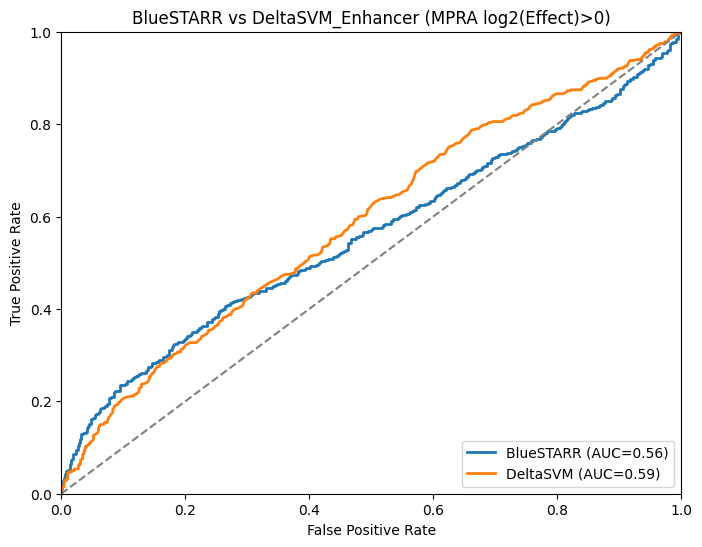

In [43]:
fpr_b, tpr_b, _ = roc_curve(gain['label'], gain['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(gain['label'], gain['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer (MPRA log2(Effect)>0)")
plt.legend(loc="lower right")

plt.show()

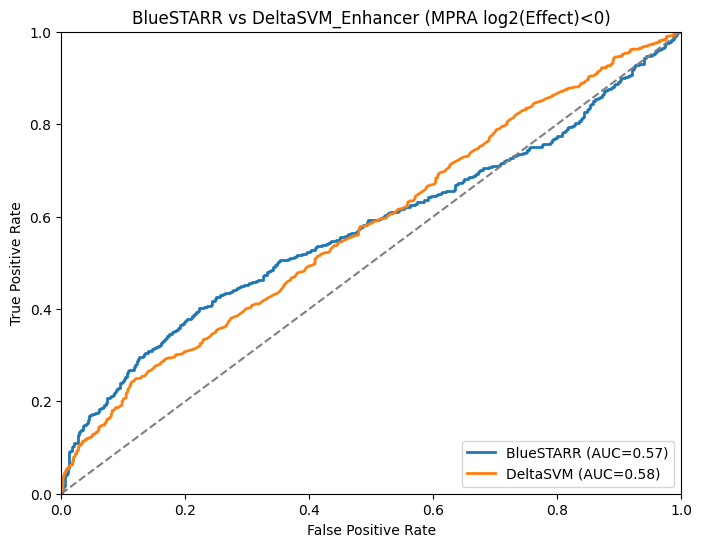

In [44]:
fpr_b, tpr_b, _ = roc_curve(loss['label'], -loss['log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(loss['label'], -loss['delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer (MPRA log2(Effect)<0)")
plt.legend(loc="lower right")

plt.show()

/tmp/ipykernel_1495623/1024013702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all.loc[:, 'abs_log2FC'] = all['log2FC'].abs()
/tmp/ipykernel_1495623/1024013702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all.loc[:, 'abs_delta'] = all['delta'].abs()


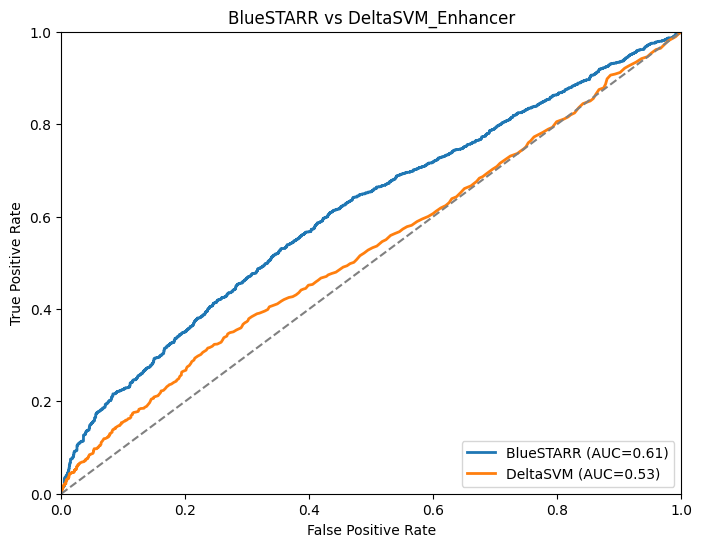

In [45]:
all.loc[:, 'abs_log2FC'] = all['log2FC'].abs()
all.loc[:, 'abs_delta'] = all['delta'].abs()

fpr_b, tpr_b, _ = roc_curve(all['label'], all['abs_log2FC'])
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(all['label'], all['abs_delta'])
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer")
plt.legend(loc="lower right")

plt.show()

only use top N TPs (highest expression effect) with N = 200, 500, and 1000 + equal number of randomly selected TNs

Plots are divided into the classification of
the top 200, 500 and 1000 high-effect promoter variants (p-value < 10-5
, min tags 10)
versus the same number of random variants (per element) with no expression effect (log2
value < 0.05, min tags 10). 

In [11]:
dbk = pd.read_csv('/work/igvf-pm/K562/mdl_eval/BlueSTARR_vs_DeltaSVM/blue_kircher_delta_enh.csv.gz', compression='gzip')
dbk.loc[(dbk['mpra_p_value']<1e-5) & (dbk['mpra_tags']>=10), 'label'] = 1
dbk.loc[(dbk['mpra_tags']>=10) & (dbk['mpra_max_log2effect'].abs()<0.05), 'label'] = 0

dbk_TF_200 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['mpra_max_log2effect'], ascending=False)[:200]
dbk_TN_200 = dbk.loc[dbk['label'] == 0, ].sample(n=200, random_state=42)
dbk_top200 = pd.concat([dbk_TF_200, dbk_TN_200], ignore_index=True)
dbk_top200['label'].value_counts()


label
1.0    200
0.0    200
Name: count, dtype: int64

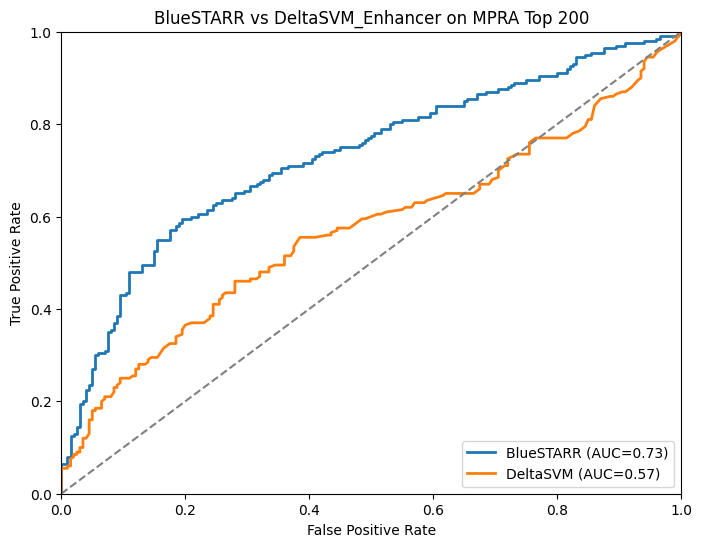

In [12]:

fpr_b, tpr_b, _ = roc_curve(dbk_top200['label'], dbk_top200['log2FC'].abs())
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(dbk_top200['label'], dbk_top200['delta'].abs())
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer on MPRA Top 200")
plt.legend(loc="lower right")

plt.show()

In [13]:
dbk_TF_500 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['mpra_max_log2effect'], ascending=False)[:500]
dbk_TN_500 = dbk.loc[dbk['label'] == 0, ].sample(n=500, random_state=42)
dbk_top500 = pd.concat([dbk_TF_500, dbk_TN_500], ignore_index=True)
dbk_top500['label'].value_counts()

label
1.0    500
0.0    500
Name: count, dtype: int64

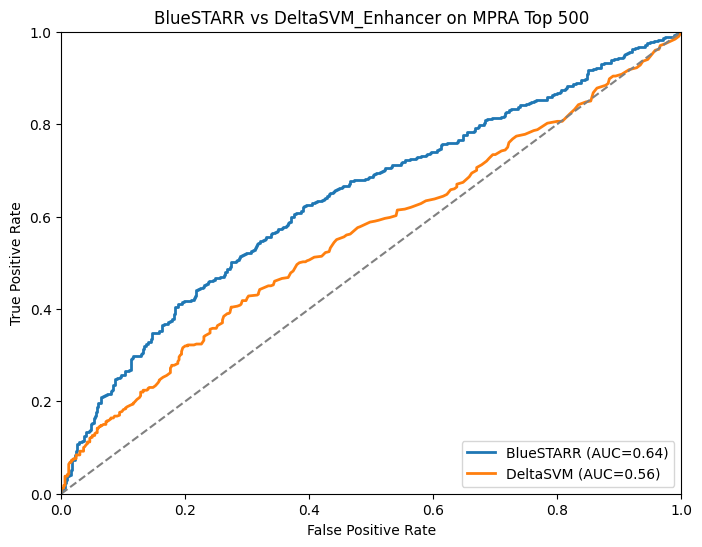

In [14]:
fpr_b, tpr_b, _ = roc_curve(dbk_top500['label'], dbk_top500['log2FC'].abs())
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(dbk_top500['label'], dbk_top500['delta'].abs())
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer on MPRA Top 500")
plt.legend(loc="lower right")

plt.show()

In [7]:
dbk_TF_1000 = dbk.loc[dbk['label'] == 1, ].sort_values(by=['mpra_max_log2effect'], ascending=False)[:1000]
dbk_TN_1000 = dbk.loc[dbk['label'] == 0, ].sample(n=1000, random_state=42)
dbk_top1000 = pd.concat([dbk_TF_1000, dbk_TN_1000], ignore_index=True)
dbk_top1000['label'].value_counts()

label
1.0    1000
0.0    1000
Name: count, dtype: int64

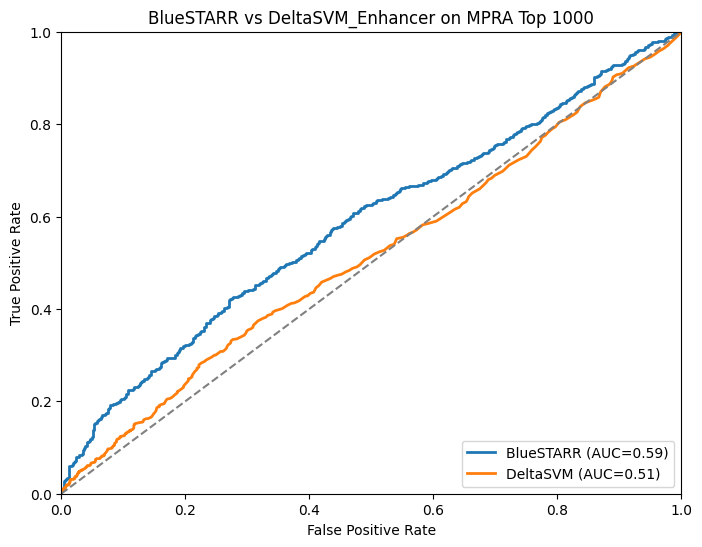

In [8]:
fpr_b, tpr_b, _ = roc_curve(dbk_top1000['label'], dbk_top1000['log2FC'].abs())
auc_b = auc(fpr_b, tpr_b)
fpr_d, tpr_d, _ = roc_curve(dbk_top1000['label'], dbk_top1000['delta'].abs())
auc_d = auc(fpr_d, tpr_d)

plt.figure(figsize=(8,6))
plt.plot(fpr_b, tpr_b, lw=2, label=f"BlueSTARR (AUC={auc_b:.2f})")
plt.plot(fpr_d, tpr_d, lw=2, label=f"DeltaSVM (AUC={auc_d:.2f})")
plt.plot([0,1], [0,1], color = 'grey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("BlueSTARR vs DeltaSVM_Enhancer on MPRA Top 1000")
plt.legend(loc="lower right")

plt.show()